In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import timeit
import json

os.environ["DGLBACKEND"] = "pytorch"

from dgl import from_networkx
from dgl.nn.pytorch import EdgeWeightNorm
import networkx as nx


import torch as th
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import itertools

from src.models import EGRAPHSAGE, EGAT, EGCN
from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures

# datasets = {dataset.name: dataset for dataset in datasets_list}

num_epochs = 1000
batch_size = 128
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001

e_gcn = False

e_gcn_res = False

e_graph_sage = True

e_graph_sage_res = True

e_gat = False

e_gat_res = False

In [2]:
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017_5_percent"
name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"

num_neighbors = [25, 10]
# num_neighbors = [4, 4]
# num_neighbors = None

with_centralities = False

node_features = False
# node_features = True
node_features_version = 2

validate = False
validate_epoch = 1

multi_class = True

suffix = ""
if with_centralities:
    suffix = "_with_centralities"
elif node_features:
    if node_features_version == 3:
        suffix = "_node_features_2"
    else:
        suffix = "_node_features"

if multi_class:
    suffix += "_multi_class"

dataset = datasets[name]

In [3]:
results_final = {}

results_final["name"] = name
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": num_neighbors,
    "with_centralities": with_centralities,
    "node_features": node_features,
    "node_features_version": node_features_version,
    # "early_stopping": early_stopping,
    # "pca": pca,
    # "digraph_centralities": digraph_centralities,
    # "multi_graph_centralities": multi_graph_centralities,
    # "learning_rate": learning_rate,
    # "LAMBD_1": LAMBD_1,
    # "LAMBD_2": LAMBD_2,
    # "cfg": OmegaConf.to_container(cfg)
}

results_final["accuracy"] = {}
results_final["time_elapsed"] = {}

if e_gcn:
    results_final["e_gcn"] = {}

if e_gcn_res:
    results_final["e_gcn_res"] = {}

if e_graph_sage:
    results_final["e_graph_sage"] = {}

if e_graph_sage_res:
    results_final["e_graph_sage_res"] = {}

if e_gat:
    results_final["e_gat"] = {}

if e_gat_res:
    results_final["e_gat_res"] = {}

results_final["val_accuracy"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

results_final

{'name': 'cic_ids_2017',
 'configuration': {'num_epochs': 1000,
  'multi_class': True,
  'batch_size': 128,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'node_features': False,
  'node_features_version': 2},
 'accuracy': {},
 'time_elapsed': {},
 'e_graph_sage': {},
 'e_graph_sage_res': {},
 'val_accuracy': {},
 'val_precision': {},
 'val_recall': {},
 'val_f1': {},
 'val_FPR': {},
 'val_FNR': {}}

In [4]:
def calculate_FPR_FNR(cm):

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    return FPR, FNR

In [5]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20241218-160300'

In [6]:
results_folder_path = "results"
if not os.path.isdir(results_folder_path):
    os.mkdir(results_folder_path)

results_folder_path1 = os.path.join(results_folder_path, name)
if not os.path.isdir(results_folder_path1):
    os.mkdir(results_folder_path1)

folder_path = os.path.join(results_folder_path1, dtime)
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
if not os.path.isdir(confusion_matrices_path):
    os.mkdir(confusion_matrices_path)

In [7]:
with open(f"datasets/{name}/training_graph{suffix}.pkl", "rb") as f:
    G = pickle.load(f)

In [8]:
# nx.diameter(G)

In [9]:
if node_features:
    G = from_networkx(G,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])
else:
    G = from_networkx(G,  edge_attrs=['h', dataset.label_col])


In [10]:
num_features = G.edata['h'].shape[1]
num_features

31

In [11]:
if node_features:
    # G.ndata["h"] = th.cat([G.ndata["n_feats"], th.ones(G.num_nodes(), num_features)], dim=1)
    G.ndata["h"] = G.ndata["n_feats"]
else:
    G.ndata['h'] = th.ones(G.num_nodes(), num_features)
    
ndim_in = G.ndata["h"].shape[-1]

G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, ndim_in))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, num_features))

G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [12]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(
                                                      G.edata[dataset.label_col].cpu().numpy()),
                                                  y=G.edata[dataset.label_col].cpu().numpy())

In [13]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [14]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [15]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [16]:
if node_features:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])  
else:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col])

In [17]:
actual_label = G_test.edata.pop(dataset.label_col)

if node_features:
    # G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
    G_test.ndata["feature"] = G_test.ndata["n_feats"]
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

ndim_in = G_test.ndata["feature"].shape[-1]

In [18]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [19]:
def test_gnn(model, graph, norm=False):
    start_time = timeit.default_timer()

    if norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
    test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [20]:
len(G.edata[dataset.label_col].unique())

15

In [21]:
def train_gnn(model_class, Graph, residual, model_name, num_neighbors=None, norm=None):
    node_features = Graph.ndata['h']
    edge_features = Graph.edata['h']

    edge_label = Graph.edata[dataset.label_col]
    train_mask = Graph.edata['train_mask']

    # model = EGRAPHSAGE(num_features, num_features, 128, F.relu,
    #                    dropout=0.2, num_neighbors=4, residual=residual)

    if norm:
        edge_weight = th.ones(Graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(Graph, edge_weight)
        Graph.edata['norm_weight'] = norm_edge_weight

    if num_neighbors:
        model = model_class(ndim_in, num_features, 128, F.relu,
                            dropout=0.2, num_neighbors=num_neighbors, residual=residual, num_class=len(G.edata[dataset.label_col].unique()))
    else:
        model = model_class(ndim_in, num_features, 128, F.relu,
                            dropout=0.2, residual=residual, num_class=len(G.edata[dataset.label_col].unique()))

    opt = th.optim.Adam(model.parameters(), lr=learning_rate)

    val_acc = []
    val_precision = []
    val_recall = []
    val_f1 = []
    val_FPR = []
    val_FNR = []
    for epoch in range(1, num_epochs):
        #     pred = model(G, node_features,edge_features).cuda()
        pred = model(Graph, node_features, edge_features)
        # print(pred.shape)
        # print(pred[0])
        loss = criterion(pred[train_mask], edge_label[train_mask])
        opt.zero_grad()
        loss.backward()
        opt.step()
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(
            pred[train_mask], edge_label[train_mask]))
        if validate and epoch % validate_epoch == 0:
            actual, test_pred, elapsed = test_gnn(model, G_test, norm=True)
            cr = classification_report(actual, test_pred, digits=4, output_dict=True)
            val_acc.append(cr["accuracy"])
            val_precision.append(cr['weighted avg']['precision'])
            val_recall.append(cr['weighted avg']['recall'])
            val_f1.append(cr['weighted avg']['f1-score'])

            cm = confusion_matrix(actual, test_pred, labels=labels)
            FPR, FNR = calculate_FPR_FNR(cm)
            val_FPR.append(FPR)
            val_FNR.append(FNR)
            print(cr["accuracy"])
    if validate:
        results_final["val_accuracy"][model_name] = val_acc
        results_final["val_precision"][model_name] = val_precision
        results_final["val_recall"][model_name] = val_recall
        results_final["val_f1"][model_name] = val_f1
        results_final["val_FPR"][model_name] = val_FPR
        results_final["val_FNR"][model_name] = val_FNR
    return model

### Training EGCN

In [22]:
if e_gcn:
    model_gcn = train_gnn(EGCN, G, False, "e_gcn", None, True)

### Training EGCN residual

In [23]:
if e_gcn_res:
    model_gcn_res = train_gnn(EGCN, G, True, "e_gcn_res", None, True)

### Training EGraphSage 

In [24]:
if e_graph_sage:
    model_sage = train_gnn(EGRAPHSAGE, G, False, "e_graph_sage", num_neighbors=num_neighbors)

Epoch: 1  Training acc: 0.0796213373541832
Epoch: 2  Training acc: 0.0876876637339592
Epoch: 3  Training acc: 0.005836844444274902
Epoch: 4  Training acc: 0.08349108695983887
Epoch: 5  Training acc: 0.0014727868838235736
Epoch: 6  Training acc: 0.007164484355598688
Epoch: 7  Training acc: 0.10647609829902649
Epoch: 8  Training acc: 0.14833228290081024
Epoch: 9  Training acc: 0.3096780776977539
Epoch: 10  Training acc: 0.27612927556037903
Epoch: 11  Training acc: 0.46625885367393494
Epoch: 12  Training acc: 0.5842188596725464
Epoch: 13  Training acc: 0.6266241669654846
Epoch: 14  Training acc: 0.6459352970123291
Epoch: 15  Training acc: 0.7024985551834106
Epoch: 16  Training acc: 0.7237981557846069
Epoch: 17  Training acc: 0.6367824077606201
Epoch: 18  Training acc: 0.6449618935585022
Epoch: 19  Training acc: 0.6054118871688843
Epoch: 20  Training acc: 0.5682470798492432
Epoch: 21  Training acc: 0.559389054775238
Epoch: 22  Training acc: 0.48638203740119934
Epoch: 23  Training acc: 0.32

### Training EGraphSage residual

In [25]:
if e_graph_sage_res:
    model_sage_res = train_gnn(EGRAPHSAGE, G, True, "e_graph_sage_res", num_neighbors=num_neighbors)

Epoch: 1  Training acc: 0.02384270541369915
Epoch: 2  Training acc: 0.025635728612542152
Epoch: 3  Training acc: 0.05479457601904869
Epoch: 4  Training acc: 0.03969419747591019
Epoch: 5  Training acc: 0.11256111413240433
Epoch: 6  Training acc: 0.10681308805942535
Epoch: 7  Training acc: 0.2375181019306183
Epoch: 8  Training acc: 0.32449981570243835
Epoch: 9  Training acc: 0.5865447521209717
Epoch: 10  Training acc: 0.6591726541519165
Epoch: 11  Training acc: 0.6944068670272827
Epoch: 12  Training acc: 0.6785533428192139
Epoch: 13  Training acc: 0.6857589483261108
Epoch: 14  Training acc: 0.7285544872283936
Epoch: 15  Training acc: 0.7581244111061096
Epoch: 16  Training acc: 0.7770488858222961
Epoch: 17  Training acc: 0.7224334478378296
Epoch: 18  Training acc: 0.7308245897293091
Epoch: 19  Training acc: 0.6803270578384399
Epoch: 20  Training acc: 0.6824119091033936
Epoch: 21  Training acc: 0.7255399227142334
Epoch: 22  Training acc: 0.5636439919471741
Epoch: 23  Training acc: 0.456221

### Training EGAT

In [26]:
if e_gat:
    model_gat = train_gnn(EGAT, G, False, "e_gat", None)

### Training EGAT residual

In [27]:
if e_gat_res:
    model_gat_res = train_gnn(EGAT, G, True, "e_gat_res", None)

# Testing

In [28]:
labels = ["Normal", "Attack"]
if multi_class:
    with open(f"datasets/{name}/labels_names.pkl", "rb") as f:
        labels_names = pickle.load(f)
    labels = labels_names[1]
labels

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [29]:
with open(f"datasets/{name}/testing_graph{suffix}.pkl", "rb") as f:
    G_test = pickle.load(f)

In [30]:
if node_features:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col], node_attrs=["n_feats"])  
else:
    G_test = from_networkx(G_test,  edge_attrs=['h', dataset.label_col])

In [31]:
actual_label = G_test.edata.pop(dataset.label_col)

if node_features:
    # G_test.ndata["feature"] = th.cat([G_test.ndata["n_feats"], th.ones(G_test.num_nodes(), num_features)], dim=1)
    G_test.ndata["feature"] = G_test.ndata["n_feats"]
else:
    G_test.ndata['feature'] = th.ones(G_test.num_nodes(),  num_features)

ndim_in = G_test.ndata["feature"].shape[-1]

In [32]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [33]:
def test_gnn(model, graph, norm=False):
    start_time = timeit.default_timer()

    if norm:
        edge_weight = th.ones(graph.num_edges(), dtype=th.float32)
        norm = EdgeWeightNorm(norm='both')
        norm_edge_weight = norm(graph, edge_weight)
        graph.edata['norm_weight'] = norm_edge_weight

    node_features_test = graph.ndata['feature']
    edge_features_test = graph.edata['h']
    # test_pred = model(G_test, node_features_test, edge_features_test).cuda()
    test_pred = model(graph, node_features_test, edge_features_test)
    elapsed = timeit.default_timer() - start_time
    print(str(elapsed) + ' seconds')

    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual_label)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual_label]
        
    if multi_class:
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    return (actual, test_pred, elapsed)

In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          file_path=None):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    if file_path:
        plt.savefig(file_path)
    plt.show()

### Testing EGCN

In [35]:
if e_gcn:
    actual, test_pred, elapsed = test_gnn(model_gcn, G_test, norm=True)

In [36]:
if e_gcn:
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [37]:
if e_gcn:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn.png')

In [38]:
if e_gcn:
    FPR, FNR = calculate_FPR_FNR(cm)

In [39]:
if e_gcn:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn"]["elapsed"] = elapsed
    results_final["e_gcn"]["classification_report"] = cr
    results_final["e_gcn"]["FPR"] = FPR
    results_final["e_gcn"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGCN residual

In [40]:
if e_gcn_res:
    actual, test_pred, elapsed = test_gnn(model_gcn_res, G_test, norm=True)

In [41]:
if e_gcn_res:
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [42]:
if e_gcn_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gcn_res.png')

In [43]:
if e_gcn_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [44]:
if e_gcn_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gcn_res"]["elapsed"] = elapsed
    results_final["e_gcn_res"]["classification_report"] = cr
    results_final["e_gcn_res"]["FPR"] = FPR
    results_final["e_gcn_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gcn_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gcn_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGraphSage

In [45]:
if e_graph_sage:
    actual, test_pred, elapsed = test_gnn(model_sage, G_test)

0.5145964995026588 seconds


In [46]:
if e_graph_sage:
    cm = confusion_matrix(actual, test_pred, labels=labels)

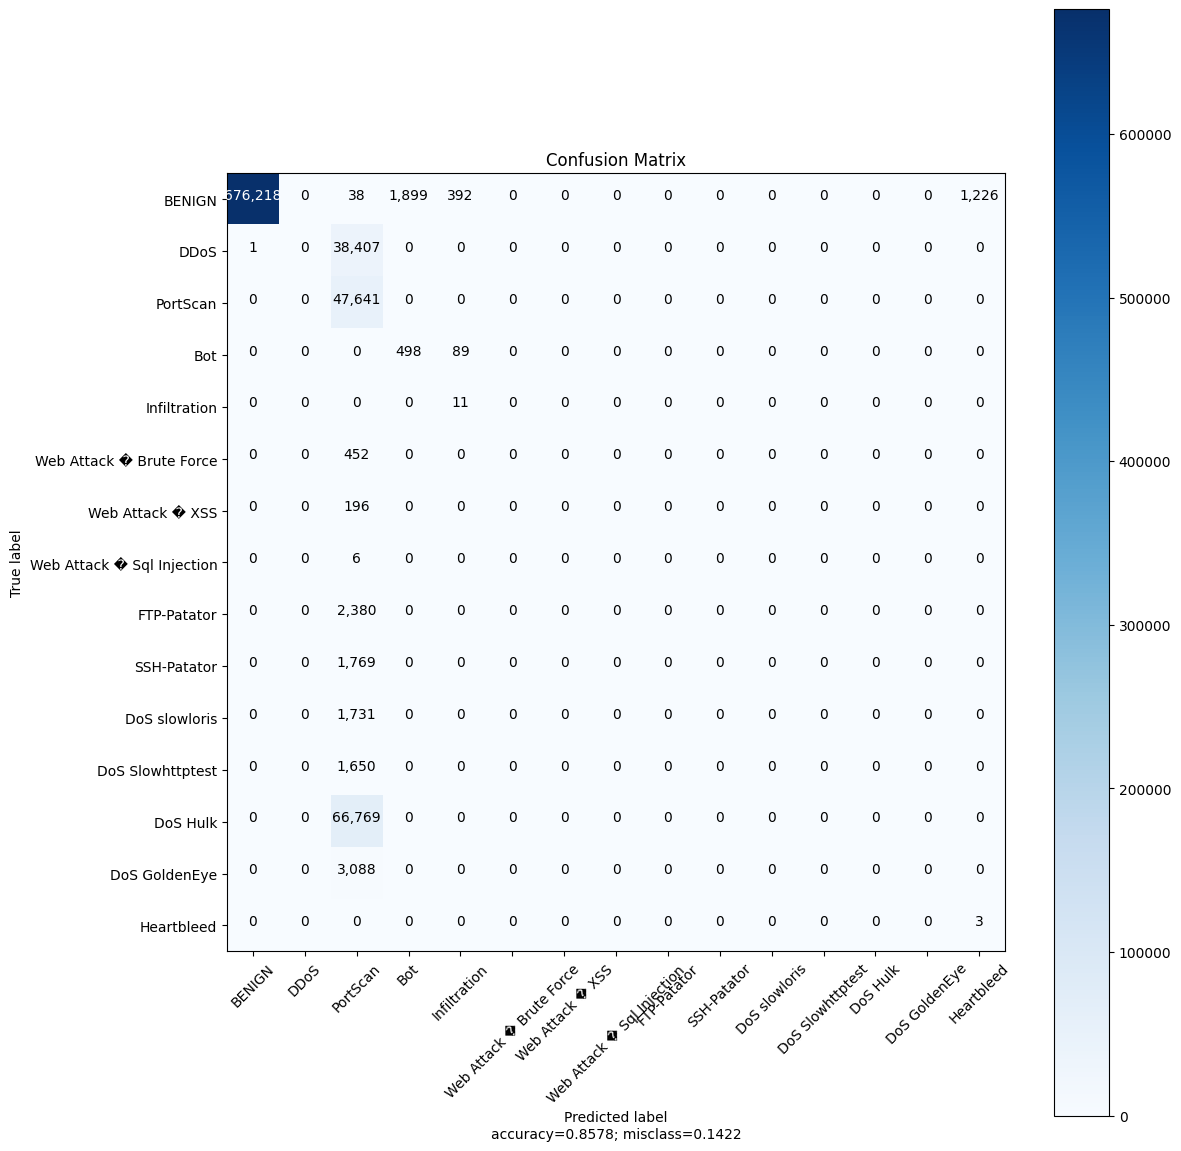

In [47]:
if e_graph_sage:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage.png')

In [48]:
if e_graph_sage:
    FPR, FNR = calculate_FPR_FNR(cm)

C:\Users\Administrateur\AppData\Local\Temp\3\ipykernel_19468\2044431763.py:13: RuntimeWarning: invalid value encountered in scalar divide
  PPV = TP/(TP+FP)
C:\Users\Administrateur\AppData\Local\Temp\3\ipykernel_19468\2044431763.py:21: RuntimeWarning: invalid value encountered in scalar divide
  FDR = FP/(TP+FP)


In [49]:
if e_graph_sage:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage"]["elapsed"] = elapsed
    results_final["e_graph_sage"]["classification_report"] = cr
    results_final["e_graph_sage"]["FPR"] = FPR
    results_final["e_graph_sage"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.9948    0.9974    679773
                       Bot     0.2078    0.8484    0.3338       587
                      DDoS     0.0000    0.0000    0.0000     38408
             DoS GoldenEye     0.0000    0.0000    0.0000      3088
                  DoS Hulk     0.0000    0.0000    0.0000     66769
          DoS Slowhttptest     0.0000    0.0000    0.0000      1650
             DoS slowloris     0.0000    0.0000    0.0000      1731
               FTP-Patator     0.0000    0.0000    0.0000      2380
                Heartbleed     0.0024    1.0000    0.0049         3
              Infiltration     0.0224    1.0000    0.0437        11
                  PortScan     0.2903    1.0000    0.4499     47641
               SSH-Patator     0.0000    0.0000    0.0000      1769
  Web Attack � Brute Force     0.0000    0.0000    0.0000       452
Web Attack � Sql Injection     0.0000    0.0000

c:\Users\Administrateur\Desktop\GNN-NIDS\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Testing EGraphSage residual

In [50]:
if e_graph_sage_res:
    actual, test_pred, elapsed = test_gnn(model_sage_res, G_test)

0.7298236005008221 seconds


In [51]:
test_pred

array(['BENIGN', 'BENIGN', 'BENIGN', ..., 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype='<U26')

In [52]:
if e_graph_sage_res:
    cm = confusion_matrix(actual, test_pred, labels=labels)

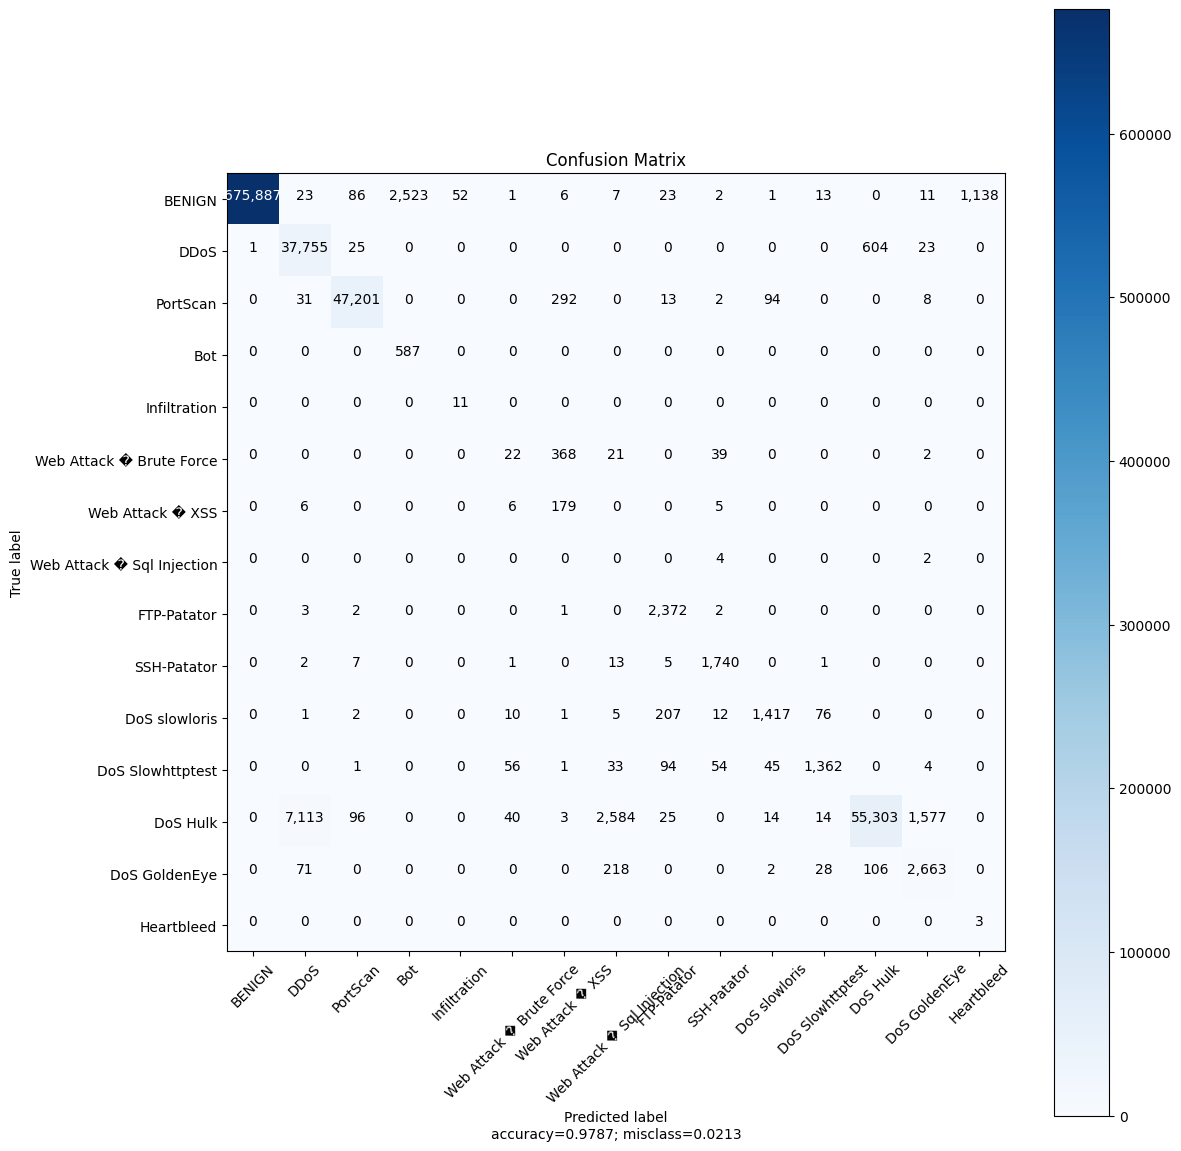

In [53]:
if e_graph_sage_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_graph_sage_res.png')

In [54]:
if e_graph_sage_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [55]:
if e_graph_sage_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_graph_sage_res"]["elapsed"] = elapsed
    results_final["e_graph_sage_res"]["classification_report"] = cr
    results_final["e_graph_sage_res"]["FPR"] = FPR
    results_final["e_graph_sage_res"]["FNR"] = FNR
    results_final["accuracy"]["e_graph_sage_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_graph_sage_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

                            precision    recall  f1-score   support

                    BENIGN     1.0000    0.9943    0.9971    679773
                       Bot     0.1887    1.0000    0.3176       587
                      DDoS     0.8389    0.9830    0.9053     38408
             DoS GoldenEye     0.6207    0.8624    0.7219      3088
                  DoS Hulk     0.9873    0.8283    0.9008     66769
          DoS Slowhttptest     0.9116    0.8255    0.8664      1650
             DoS slowloris     0.9008    0.8186    0.8577      1731
               FTP-Patator     0.8660    0.9966    0.9267      2380
                Heartbleed     0.0026    1.0000    0.0052         3
              Infiltration     0.1746    1.0000    0.2973        11
                  PortScan     0.9954    0.9908    0.9931     47641
               SSH-Patator     0.9355    0.9836    0.9589      1769
  Web Attack � Brute Force     0.1618    0.0487    0.0748       452
Web Attack � Sql Injection     0.0000    0.0000

### Testing EGAT

In [56]:
if e_gat:
    actual, test_pred, elapsed = test_gnn(model_gat, G_test)

In [57]:
if e_gat:
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [58]:
if e_gat:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat.png')

In [59]:
if e_gat:
    FPR, FNR = calculate_FPR_FNR(cm)

In [60]:
if e_gat:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat"]["elapsed"] = elapsed
    results_final["e_gat"]["classification_report"] = cr
    results_final["e_gat"]["FPR"] = FPR
    results_final["e_gat"]["FNR"] = FNR
    results_final["accuracy"]["e_gat"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Testing EGAT residual

In [61]:
if e_gat_res:
    actual, test_pred, elapsed = test_gnn(model_gat_res, G_test)

In [62]:
if e_gat_res:
    cm = confusion_matrix(actual, test_pred, labels=labels)

In [63]:
if e_gat_res:
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title="Confusion Matrix",
                          file_path=confusion_matrices_path + '/e_gat_res.png')

In [64]:
if e_gat_res:
    FPR, FNR = calculate_FPR_FNR(cm)

In [65]:
if e_gat_res:
    cr = classification_report(actual, test_pred, digits=4, output_dict=True)
    results_final["e_gat_res"]["elapsed"] = elapsed
    results_final["e_gat_res"]["classification_report"] = cr
    results_final["e_gat_res"]["FPR"] = FPR
    results_final["e_gat_res"]["FNR"] = FNR
    results_final["accuracy"]["e_gat_res"] = cr["accuracy"]
    results_final["time_elapsed"]["e_gat_res"] = elapsed

    print(classification_report(actual, test_pred, digits=4))

### Saving results

In [66]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)


filename = (folder_path + '/results.json'.format(dtime))
outfile = open(filename, 'w')
outfile.writelines(json.dumps(results_final, cls=NumpyEncoder))
outfile.close()